In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr
import xarray as xr
import numpy as np
from pathlib import Path

from utils.data import load_config_xval_test_set, load_xval_test_set
from utils.analysis import plot_model_comp, xval_station_metrics, get_cdf
from utils.metrics import compute_metrics
from utils.plotting import load_default_mpl_config, savefig

load_default_mpl_config()

PLOT_PATH = Path('/mydata/machflow/basil/mach-flow/analysis/staticperf_vis/')

def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.to_dataframe().reset_index()
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both

/mydata/machflow/basil/mambaforge/envs/machflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
static_names = dict(
    water=1,
    urban_areas=2,
    coniferous_forests=3,
    deciduous_forests=4,
    mixed_forests=5,
    cereals=6,
    pasture=7,
    bush=8,
    unknown=10,
    firn=13,
    bare_ice=14,
    rock=15,
    fruits=18,
    vegetables=19,
    wheat=20,
    alpine_vegetation=21,
    wetlands=22,
    rough_pasture=23,
    sub_Alpine_meadow=24,
    alpine_meadow=25,
    bare_soil_vegetation=26,
    corn=28,
    grapes=29,
)

In [3]:
ds = load_xval_test_set('../../runs/basin_level/staticall_allbasins_sqrttrans/LSTM/xval/').sel(tau=0.5).drop_vars('tau').sel(time=slice('2012', None))

static_vars = [
    'area',
    'abb',
    'atb',
    'btk',
    'dhm',
    'folds',
    'glm',
    'kwt',
    'pfc',
    'slp',
    'Qmm_mean',
    'Qmm_std'
]

ds['Qmm_mean'] = ds.Qmm.mean('time').compute()
ds['Qmm_std'] = ds.Qmm.std('time').compute()

for name, uid in static_names.items():
    pus_id = f'pus{uid:02d}'
    if pus_id in ds.data_vars:
        ds = ds.rename({pus_id: name})
        static_vars.append(name)

metrics = ['bias2', 'varerr', 'phaseerr']

x_mod = compute_metrics(obs=ds.Qmm, mod=ds.Qmm_mod, dim='time')
x_prevah = compute_metrics(obs=ds.Qmm, mod=ds.Qmm_prevah, dim='time')
x_diff = (x_prevah - x_mod)[metrics]
x_diff = x_diff.rename({var: f'{var}_diff' for var in x_diff.data_vars})
x_perf = x_mod[metrics]

ds = xr.merge((ds, x_diff, x_perf))

In [4]:
rank_mat = np.full((len(static_vars), len(metrics)), np.nan)
rank_mat_diff = np.full((len(static_vars), len(metrics)), np.nan)

for r, metric in enumerate(metrics):
    for c, var in enumerate(static_vars):
        rank_mat[c, r] = spearmanr(ds[var], ds[metric]).statistic
        rank_mat_diff[c, r] = spearmanr(ds[var], ds[f'{metric}_diff']).statistic

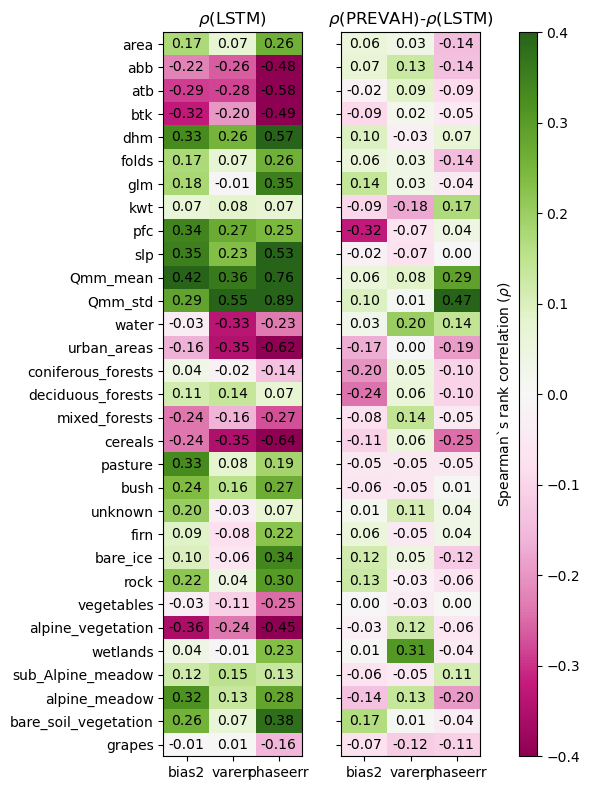

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(6, 8), gridspec_kw={'width_ratios': [8, 8, 1]})

for i, nm in enumerate([r'$\rho$(LSTM)', r'$\rho$(PREVAH)-$\rho$(LSTM)']):

    ax = axes[i]
    if i == 0:
        mat = rank_mat
    else:
        mat = rank_mat_diff

    im = ax.imshow(mat, aspect='auto', cmap='PiYG', vmin=-0.4, vmax=0.4)

    ax.set_yticks(range(len(static_vars)))
    if i == 0:
        ax.set_yticklabels(static_vars);
    else:
        ax.set_yticklabels([]);
        plt.colorbar(im, cax=axes[2])

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(metrics)

    for (j, i), _ in np.ndenumerate(rank_mat):
        label = f'{mat[j, i]:0.2f}'
        ax.text(i, j, label, ha='center', va='center')



    ax.set_title(nm)

axes[2].set_ylabel(r'Spearman`s rank correlation ($\rho$)')
axes[2].yaxis.set_label_position('left')

savefig(fig, path=PLOT_PATH / 'static_perf.png')

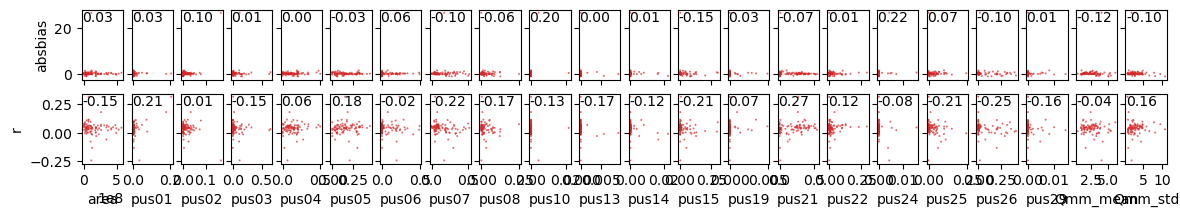

In [48]:
fix, axes = plt.subplots(len(metrics), len(static_vars), figsize=(14, 1 * len(metrics)), sharey='row' , sharex='col')

for r, metric in enumerate(metrics):
    for c, var in enumerate(static_vars):
        ax = axes[r, c]
        x = ds[var]
        y = ds[metric]
        ax.scatter(x, y, s=2, alpha=0.7, edgecolor='none', facecolor='tab:red')

        spearman_r = spearmanr(x, y).statistic
        plt.text(0.01, 0.99, f'{spearman_r:0.2f}', ha='left', va='top', transform=ax.transAxes)

        if c == 0:
            ax.set_ylabel(metric)

        if r == len(metrics) - 1:
            ax.set_xlabel(var)

In [19]:
best = load_xval_test_set(
    xval_dir='/mydata/machflow/basil/runs/basin_level/staticall_allbasins_sqrttrans/LSTM/xval/',
    time_slices=['1995,1999', '2016,2020']).sel(tau=0.5).drop_vars('tau')

In [20]:
mask = best.Qmm_mod.notnull() & best.Qmm_prevah.notnull()
best['Qmm_mod'] = best['Qmm_mod'].where(mask)
best['Qmm_prevah'] = best['Qmm_prevah'].where(mask)
best = best.compute()

In [41]:
metrics = ['bias2', 'varerr', 'phaseerr']
metric_labels = ['Squared bias', 'Variance error', 'Phase error']

x_mod = compute_metrics(obs=best.Qmm, mod=best.Qmm_mod, dim='time')
x_prevah = compute_metrics(obs=best.Qmm, mod=best.Qmm_prevah, dim='time')
x_diff = (x_prevah - x_mod)[metrics]
x_diff = x_diff.rename({var: f'{var}_diff' for var in x_diff.data_vars})
x_perf = x_mod[metrics]

perf = xr.combine_by_coords((x_mod.expand_dims(source=['LSTM']), x_prevah.expand_dims(source=['PREVAH'])))

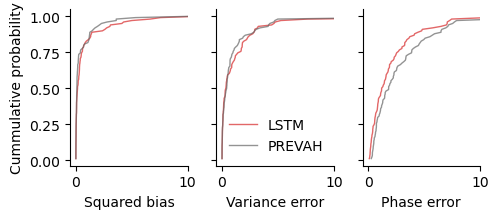

In [66]:
fig, axes = plt.subplots(1, len(metrics), figsize=(5, 2.3), sharey=True)

for m, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[m]

    for s, (source, color) in enumerate(zip(['LSTM', 'PREVAH'], ['tab:red', '0.4'])):
        da = perf.sel(source=source)[metric]

        bins, cdf, xloc = get_cdf(da)

        ax.plot(bins, cdf, label=source, color=color, alpha=0.7, lw=1.)

    ax.set_xlabel(metric_label)
    ax.set_xlim(-0.5, 10)
    ax.spines[['right', 'top']].set_visible(False)

axes[1].legend(frameon=False)
axes[0].set_ylabel('Cummulative probability')

savefig(fig, path=PLOT_PATH / 'mse_decomp.png')
